# Alphavirus RdRp conservation Analysis

# Direct Coupling Analysis (DCA), direct information (DI)

Traditional covariance methods can identify correlated variables (like amino acid residues in proteins that change together) but can't differentiate if these correlations are direct (two variables directly influencing each other) or indirect (their correlation is due to both being influenced by a third variable).  

DCA goes beyond traditional covariance methods by attempting to infer direct interactions between variables (e.g., amino acid residues in a protein) from large multiple sequence alignments (MSAs). The output of DCA includes scores for pairs of positions in a sequence, indicating the strength and likelihood that they interact directly, rather than merely appearing to interact due to indirect effects mediated by other positions.  

### How DCA Works
**Multiple Sequence Alignment**: DCA begins with an MSA, which aligns sequences from similar proteins across different species or variants. This alignment helps identify conserved and variable positions across sequences.    

**Covariance Calculation**: DCA calculates the covariance for each pair of positions in the MSA. High covariance suggests that changes in one position often coincide with changes in another, which might indicate some form of interaction.    

**Inferring Direct Interactions**:
Unlike simpler covariance methods, DCA uses statistical models to differentiate direct interactions from indirect correlations.
The model assigns a score to each possible pair of residues, with higher scores indicating a stronger likelihood of direct interaction.   

**Inversion of the Covariance Matrix**: One approach within DCA involves inverting the covariance matrix of the alignment to extract direct information, which helps in separating direct from indirect interactions.

In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import Entrez, SeqIO, AlignIO
from Bio.PDB import PDBParser, PDBIO, Chain

import ast

pd.set_option('display.max_columns', 110)

In [2]:
def Zscore(column_val):
    m = np.mean(column_val)
    std = np.std(column_val)
    zscore = [((x - m)/std) for x in column_val]
    return zscore

## Covariance analysis on nsP4 - Compact Conformation

In [3]:
cov = pd.read_csv('../results/DCA/nsP4/v02/PLMDCA_FN_APC_nsp4-RdRp-compact_seqIdt0.85_lh1_lj20.txt', sep='\t')
cov['Tuple'] =  cov.apply(lambda row: (int(row['first_site']), int(row['second_site'])), axis=1)
cov = cov[['first_site', 'second_site', 'Tuple', 'APC']]
cov

,first_site,second_site,Tuple,APC
0,154,156,"(154, 156)",0.042384
1,240,473,"(240, 473)",0.042111
2,75,216,"(75, 216)",0.041125
3,89,496,"(89, 496)",0.038878
4,103,240,"(103, 240)",0.038817
...,...,...,...,...
186350,48,56,"(48, 56)",-0.017079
186351,156,510,"(156, 510)",-0.017118
186352,48,522,"(48, 522)",-0.017196
186353,76,589,"(76, 589)",-0.018060


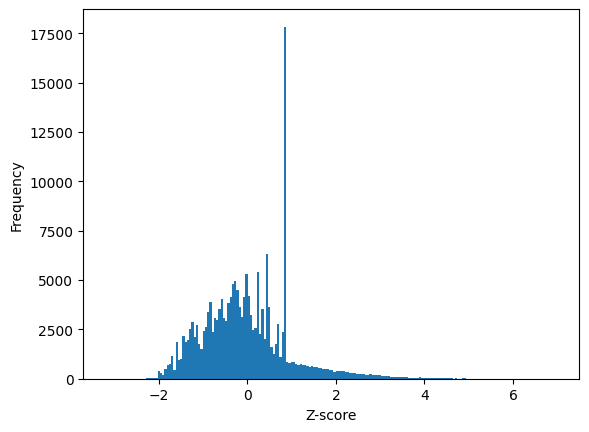

In [7]:
cov_comp_Nter = cov.query("first_site <105 or second_site < 105")

cov['Zscore'] = Zscore(cov['APC'])

cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
#plt.savefig('results/alphavirus/DCA/mfdca_nsp4_compact_Zscore_hist.png')
plt.show()

## Adding Neff

In [5]:
# neff v02 is from psiblast alignment
neff = pd.read_excel('../results/Neff/nsP4/nsp4_compact_Neff_psiblast_mapped.xlsx')

In [8]:
df1 = cov_comp_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_comp_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]].copy()

cov_comp_Nter_neff['Tuple'] = cov_comp_Nter_neff['Tuple'].astype(str)
cov_comp_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779003
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038878,6.408639
2,Pro,103,1.114821,Glu,240,2.289969,"(103, 240)",0.038817,6.398603
3,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364357
4,Gly,83,1.000000,Asn,252,1.560988,"(83, 252)",0.038298,6.312974
...,...,...,...,...,...,...,...,...,...
58585,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742413
58586,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017079,-2.816056
58587,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835364
58588,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018060,-2.977853


### Adding distance in Å

In [9]:
compact_contact = pd.read_table('../results/Distance/nsP4/nsp4-RdRp_compact_distance.txt')

cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_comp_Nter_neff.merge(compact_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779003,48.64
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038878,6.408639,48.89
2,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364357,6.33
3,Gly,83,1.000000,Asn,252,1.560988,"(83, 252)",0.038298,6.312974,14.17
4,Gln,53,1.014685,Pro,216,1.000000,"(53, 216)",0.038044,6.271192,70.05
...,...,...,...,...,...,...,...,...,...,...
55945,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742413,31.35
55946,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017079,-2.816056,11.12
55947,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835364,47.94
55948,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018060,-2.977853,43.47


### Adding rASA

In [10]:
compact_rASA = pd.read_excel('../results/RSA/nsp4_RSA_compact.xlsx', index_col=0)
compact_rASA.rename(columns={'rASA_compact': 'rASA'}, inplace=True)
compact_rASA

,Residue,position,rASA
0,Y,1,0.638783
1,I,2,0.233503
2,F,3,0.258333
3,S,4,0.212903
4,S,5,0.180645
...,...,...,...
606,Y,607,0.334601
607,G,608,0.259615
608,G,609,0.423077
609,P,610,0.911950


In [11]:
mapping = {k:v for k, v in zip(compact_rASA['position'], compact_rASA['rASA'])}

df['first_site_RSA'] = [mapping[x] for x in df['first_site']]
df['second_site_RSA'] = [mapping[x] for x in df['second_site']]

cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_RSA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_RSA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ].copy()

df2 = df[cols]
df2

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,0.285714,Pro,216,1.000000,0.421384,"(75, 216)",0.041125,6.779003,48.64
1,Ala,89,4.551939,0.232558,Ala,496,1.268383,0.000000,"(89, 496)",0.038878,6.408639,48.89
2,Ser,57,1.867111,0.419355,Asn,60,1.000000,0.133333,"(57, 60)",0.038609,6.364357,6.33
3,Gly,83,1.000000,0.134615,Asn,252,1.560988,0.025641,"(83, 252)",0.038298,6.312974,14.17
4,Gln,53,1.014685,0.591111,Pro,216,1.000000,0.421384,"(53, 216)",0.038044,6.271192,70.05
...,...,...,...,...,...,...,...,...,...,...,...,...
55945,Glu,32,3.073293,0.479821,Ile,510,1.215954,0.025381,"(32, 510)",-0.016632,-2.742413,31.35
55946,Leu,48,1.148529,0.054726,Ala,56,1.872983,0.496124,"(48, 56)",-0.017079,-2.816056,11.12
55947,Leu,48,1.148529,0.054726,Val,522,1.103899,0.028736,"(48, 522)",-0.017196,-2.835364,47.94
55948,Ile,76,2.130973,0.005076,Phe,589,1.989551,0.000000,"(76, 589)",-0.018060,-2.977853,43.47


In [14]:
df2.to_csv('../results/DCA/nsP4/v02/res_nsp4_compact_Neff_RSA_APC_Zscore_Dist_Nter.csv', index=False)

## Contacts of SOI

In [12]:
compact_cont = pd.read_excel('../results/Neff/nsP4/nsp4_compact_SOI_neff.xlsx')
compact_cont = compact_cont[~compact_cont['nsp4'].str.contains('nsp1')]
compact_cont['nsp4-Nter'].str.split('-').str[1]
compact_cont['contact_pairs'] = [x for x in zip(compact_cont['nsp4-Nter'].str.split('-').str[1].astype(int), compact_cont['nsp4'].str.split('-').str[1].astype(int))]
print(compact_cont.shape)
compact_cont

(28, 5)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,contact_pairs
0,Thr-20,4.197054,Thr-101,3.534660,"(20, 101)"
1,Thr-20,4.197054,Tyr-102,1.491985,"(20, 102)"
3,Tyr-36,1.510676,Thr-258,1.692398,"(36, 258)"
4,Lys-39,3.576069,Glu-70,1.146002,"(39, 70)"
5,Lys-81,2.954376,Thr-250,2.356040,"(81, 250)"
6,Cys-84,3.909469,Leu-253,2.721250,"(84, 253)"
7,Cys-84,3.909469,Leu-278,1.000000,"(84, 278)"
18,Glu-29,3.290982,His-31,3.652468,"(29, 31)"
19,Val-30,4.257909,Arg-99,3.108927,"(30, 99)"
20,Val-30,4.257909,Arg-332,1.000000,"(30, 332)"


In [13]:
#pairs = list(str(compact_cont['contact_pairs'].values))
pairs = [str(x) for x in compact_cont['contact_pairs'].values]
res = df2.query('Tuple in @pairs')
res.sort_values('first_site')

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
26894,Thr,20,4.197054,0.174419,Thr,101,3.534660,0.104651,"(20, 101)",-0.001064,-0.176028,6.12
19885,Thr,20,4.197054,0.174419,Tyr,102,1.491985,0.095057,"(20, 102)",0.001241,0.204085,5.92
2241,Glu,29,3.290982,0.286996,His,31,3.652468,0.553571,"(29, 31)",0.014667,2.417368,5.49
740,Val,30,4.257909,0.080460,Arg,99,3.108927,0.215328,"(30, 99)",0.019599,3.230404,6.11
54718,Val,30,4.257909,0.080460,Arg,332,1.000000,0.222628,"(30, 332)",-0.010472,-1.726849,8.26
9483,Glu,33,1.178779,0.825112,Lys,34,2.460929,0.656780,"(33, 34)",0.005351,0.881504,3.84
42317,Cys,35,5.424846,0.173653,Thr,255,3.370633,0.220930,"(35, 255)",-0.005214,-0.860060,5.84
19584,Cys,35,5.424846,0.173653,Thr,258,1.692398,0.151163,"(35, 258)",0.001348,0.221627,7.73
17438,Tyr,36,1.510676,0.646388,Thr,258,1.692398,0.151163,"(36, 258)",0.002092,0.344247,6.72
41666,Pro,37,2.216466,0.515723,Thr,254,2.494927,0.058140,"(37, 254)",-0.005146,-0.848901,6.86


In [15]:
res.sort_values('first_site').to_excel('../results/DCA/nsP4/v02/res_nsp4_compact_SOI_Neff_RSA_APC_Zscore_Dist_Nter.xlsx', index=False)

In [ ]:
stop

NameError: name 'stop' is not defined

## Covariance analysis on nsP4 - Extended Conformation

In [ ]:
cov = pd.read_csv('../results/DCA/nsP4/v02/PLMDCA_FN_APC_nsp4-RdRp-extended_seqIdt0.85_lh1_lj20.txt', sep='\t')
cov['Tuple'] =  cov.apply(lambda row: (int(row['first_site']), int(row['second_site'])), axis=1)
cov = cov[['first_site', 'second_site', 'Tuple', 'APC']]
cov

,first_site,second_site,Tuple,APC
0,154,156,"(154, 156)",0.042384
1,240,473,"(240, 473)",0.042121
2,75,216,"(75, 216)",0.041124
3,89,496,"(89, 496)",0.038879
4,103,240,"(103, 240)",0.038828
...,...,...,...,...
186350,48,56,"(48, 56)",-0.017079
186351,156,510,"(156, 510)",-0.017117
186352,48,522,"(48, 522)",-0.017195
186353,76,589,"(76, 589)",-0.018058


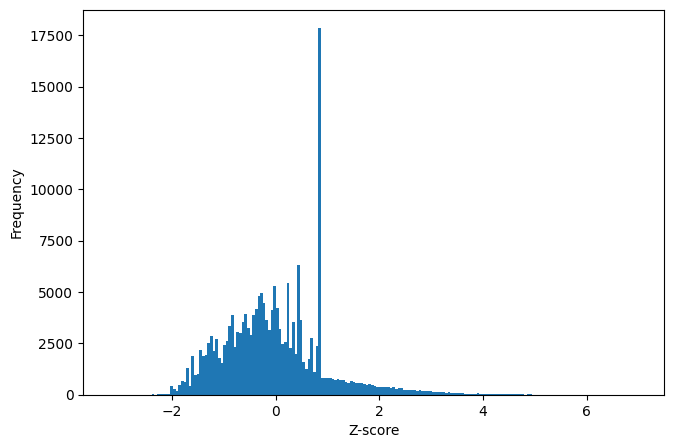

In [ ]:
cov['Zscore'] = Zscore(cov['APC'])

plt.figure(figsize=(7.5,5))
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
#plt.yscale('log')
#plt.savefig('results/DCA/nsP4/mfdca_nsp4_extended_Zscore_hist.png', dpi=400)
plt.show()

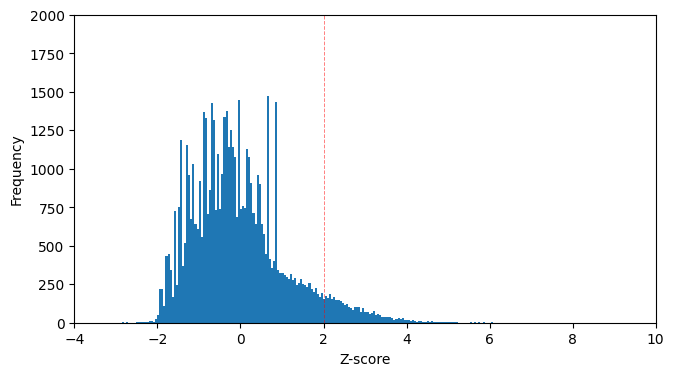

In [ ]:
cov_ext_Nter = cov.query("first_site <100 or second_site < 100")

plt.figure(figsize=(7.5, 4))
cov_ext_Nter['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.xlim(-4,10)
plt.ylim(-0,2000)
plt.vlines(2, 0, 2000, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
#plt.savefig('results/DCA/nsP4/v02/mfdca_nsp4_Nterm_extended_Zscore_hist.png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
cov_ext_Nter['Zscore'].min(), cov_ext_Nter['Zscore'].max()

(-3.20478797564631, 6.778923958531737)

## Adding Neff

In [ ]:
neff = pd.read_excel('../results/Neff/nsP4/nsp4_extended_Neff_psiblast_mapped.xlsx')

df1 = cov_ext_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_ext_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]]

cov_ext_Nter_neff = cov_ext_Nter_neff.query("Zscore > 2")
cov_ext_Nter_neff['Tuple'] = cov_ext_Nter_neff['Tuple'].astype(str) 
cov_ext_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041124,6.778924
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038879,6.408894
2,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038605,6.363734
3,Gly,83,1.000000,Asn,252,1.560988,"(83, 252)",0.038296,6.312810
4,Gln,53,1.014685,Pro,216,1.000000,"(53, 216)",0.038042,6.270906
...,...,...,...,...,...,...,...,...,...
3571,Arg,51,1.562481,Ser,499,2.675964,"(51, 499)",0.012144,2.001510
3572,Arg,99,3.108927,Phe,596,1.136985,"(99, 596)",0.012142,2.001030
3573,Asp,91,2.175003,Ser,110,3.257055,"(91, 110)",0.012141,2.000956
3574,Thr,92,5.201170,Phe,361,1.142657,"(92, 361)",0.012136,2.000079


In [ ]:
extended_contact = pd.read_table('../results/Distance/nsP4/nsp4-RdRp_extended_distance.txt')
cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_ext_Nter_neff.merge(extended_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041124,6.778924,28.06
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038879,6.408894,49.85
2,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038605,6.363734,6.48
3,Gly,83,1.000000,Asn,252,1.560988,"(83, 252)",0.038296,6.312810,26.63
4,Gln,53,1.014685,Pro,216,1.000000,"(53, 216)",0.038042,6.270906,40.45
...,...,...,...,...,...,...,...,...,...,...
3526,Arg,51,1.562481,Ser,499,2.675964,"(51, 499)",0.012144,2.001510,75.37
3527,Arg,99,3.108927,Phe,596,1.136985,"(99, 596)",0.012142,2.001030,41.40
3528,Asp,91,2.175003,Ser,110,3.257055,"(91, 110)",0.012141,2.000956,50.00
3529,Thr,92,5.201170,Phe,361,1.142657,"(92, 361)",0.012136,2.000079,40.77


In [ ]:
df1= df[df['first_site'].between(20, 90) | df['second_site'].between(20, 90) ]
df2 = df1[abs(df1['first_site'] -  df1['second_site']) >= 4].copy() 
df2 = df2.query('`Distance(Å)` < 10 & Zscore > 2')
df2

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
52,Leu,49,3.252741,Asn,60,1.000000,"(49, 60)",0.029107,4.797948,9.35
71,Arg,51,1.562481,Ser,55,5.554254,"(51, 55)",0.028167,4.642941,6.81
75,Pro,38,1.131964,Met,75,4.808267,"(38, 75)",0.028044,4.622661,8.63
84,Arg,51,1.562481,Asn,60,1.000000,"(51, 60)",0.027790,4.580800,8.19
202,Thr,20,4.197054,Val,24,4.043379,"(20, 24)",0.024337,4.011576,9.97
206,Ile,76,2.130973,Leu,80,1.334861,"(76, 80)",0.024262,3.999160,6.08
375,Gln,53,1.014685,Asn,60,1.000000,"(53, 60)",0.022146,3.650306,9.37
429,Leu,49,3.252741,Gln,53,1.014685,"(49, 53)",0.021661,3.570381,6.97
776,Leu,88,1.712180,Gln,398,3.225992,"(88, 398)",0.019387,3.195449,8.06
886,Glu,42,3.570427,Gln,46,3.559214,"(42, 46)",0.018859,3.108389,6.23


In [ ]:
extended_rASA = pd.read_excel('../results/RSA/nsp4_RSA_extended.xlsx', index_col=0)
extended_rASA.rename(columns={'rASA_extended': 'rASA'}, inplace=True)
extended_rASA

,Residue,position,rASA
0,Y,1,0.555133
1,I,2,0.040609
2,F,3,0.216667
3,S,4,0.361290
4,S,5,0.154839
...,...,...,...
606,Y,607,0.250951
607,G,608,0.317308
608,G,609,0.346154
609,P,610,0.930818


In [ ]:
mapping = {k:v for k, v in zip(extended_rASA['position'], extended_rASA['rASA'])}


df2['first_site_rASA'] = [mapping[x] for x in df2['first_site']]
df2['second_site_rASA'] = [mapping[x] for x in df2['second_site']]


cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_rASA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_rASA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ]

df2 = df2[cols].copy()
df2

,first_site_residue,first_site,first_site_Neff,first_site_rASA,second_site_residue,second_site,second_site_Neff,second_site_rASA,Tuple,APC,Zscore,Distance(Å)
52,Leu,49,3.252741,0.233831,Asn,60,1.000000,0.107692,"(49, 60)",0.029107,4.797948,9.35
71,Arg,51,1.562481,0.405109,Ser,55,5.554254,0.419355,"(51, 55)",0.028167,4.642941,6.81
75,Pro,38,1.131964,0.729560,Met,75,4.808267,0.325893,"(38, 75)",0.028044,4.622661,8.63
84,Arg,51,1.562481,0.405109,Asn,60,1.000000,0.107692,"(51, 60)",0.027790,4.580800,8.19
202,Thr,20,4.197054,0.220930,Val,24,4.043379,0.591954,"(20, 24)",0.024337,4.011576,9.97
206,Ile,76,2.130973,0.426396,Leu,80,1.334861,0.537313,"(76, 80)",0.024262,3.999160,6.08
375,Gln,53,1.014685,0.546667,Asn,60,1.000000,0.107692,"(53, 60)",0.022146,3.650306,9.37
429,Leu,49,3.252741,0.233831,Gln,53,1.014685,0.546667,"(49, 53)",0.021661,3.570381,6.97
776,Leu,88,1.712180,0.328358,Gln,398,3.225992,0.355556,"(88, 398)",0.019387,3.195449,8.06
886,Glu,42,3.570427,0.309417,Gln,46,3.559214,0.391111,"(42, 46)",0.018859,3.108389,6.23


In [ ]:
#df2.to_excel('results/DCA/nsP4/v02/nsp4_extended_contact_pairs_neff_APC_Zscore_rASA_Nter_20_90.xlsx', index=False)

## Contacts of SOI

In [ ]:
ext_cont = pd.read_excel('../results/Neff/nsP4/nsp4_extended_SOI_neff.xlsx')
ext_cont = ext_cont[~ext_cont['nsp4'].isna()]
ext_cont['nsp4-Nter'].str.split('-').str[1]
ext_cont['contact_pairs'] = [x for x in zip(ext_cont['nsp4-Nter'].str.split('-').str[1].astype(int), ext_cont['nsp4'].str.split('-').str[1].astype(int))]
print(ext_cont.shape)
ext_cont

(30, 6)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,Interaction,contact_pairs
0,Thr-20,4.197054,Tyr-102,1.491985,bb-bb (Hb),"(20, 102)"
1,Asn-25,4.029033,Thr-101,3.534660,Sc-bb (Hb),"(25, 101)"
2,Tyr-36,1.510676,Cys-233,1.000000,Sc-bb (Hb),"(36, 233)"
3,Lys-39,3.576069,Glu-226,1.106515,Sc-Sc (Hb),"(39, 226)"
4,Lys-81,2.954376,Glu-392,1.005156,NaN,"(81, 392)"
5,Lys-81,2.954376,Asp-393,1.000000,Sc-Sc (Hb),"(81, 393)"
6,Cys-84,3.909469,Ala-242,2.406731,Sc-bb (Hb),"(84, 242)"
7,Arg-85,3.167933,Asp-397,1.140274,Sc-Sc (Hb),"(85, 397)"
8,Ser-90,3.225319,Asp-91,2.175003,Sc-bb (Hb),"(90, 91)"
9,Thr-21,4.545398,Pro-103,1.114821,Sc-Sc,"(21, 103)"


In [ ]:
pairs = list(ext_cont['contact_pairs'].values)
res = cov.query('Tuple in @pairs')
res.query('Zscore > 2.0')

,first_site,second_site,Tuple,APC,Zscore
287,29,98,"(29, 98)",0.026190,4.317015
435,90,91,"(90, 91)",0.024512,4.040361
854,80,242,"(80, 242)",0.021994,3.625316
936,25,101,"(25, 101)",0.021599,3.560218
1097,84,242,"(84, 242)",0.020955,3.454008
2952,76,239,"(76, 239)",0.016858,2.778577
3605,85,397,"(85, 397)",0.015882,2.617682
4650,31,456,"(31, 456)",0.014610,2.407902


In [ ]:
cols = ['first_site', 'second_site', 'Tuple']
df = ext_cont.merge(res, how='inner', left_on='contact_pairs', right_on='Tuple').drop(cols, axis=1).sort_values('APC', ascending=False)
print(df.shape)
df

(30, 8)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,Interaction,contact_pairs,APC,Zscore
13,Glu-29,3.290982,Tyr-98,1.180829,Sc-Sc (Hb),"(29, 98)",0.026190,4.317015
8,Ser-90,3.225319,Asp-91,2.175003,Sc-bb (Hb),"(90, 91)",0.024512,4.040361
29,Leu-80,1.334861,Ala-242,2.406731,Sc-Sc,"(80, 242)",0.021994,3.625316
1,Asn-25,4.029033,Thr-101,3.534660,Sc-bb (Hb),"(25, 101)",0.021599,3.560218
6,Cys-84,3.909469,Ala-242,2.406731,Sc-bb (Hb),"(84, 242)",0.020955,3.454008
24,Ile-76,2.130973,Arg-239,2.908634,NaN,"(76, 239)",0.016858,2.778577
7,Arg-85,3.167933,Asp-397,1.140274,Sc-Sc (Hb),"(85, 397)",0.015882,2.617682
17,His-31,3.652468,Thr-456,1.865939,Sc-SC,"(31, 456)",0.014610,2.407902
12,Ile-26,3.417426,Thr-101,3.534660,Sc-Sc,"(26, 101)",0.009572,1.577377
10,Ile-26,3.417426,Tyr-98,1.180829,NaN,"(26, 98)",0.007900,1.301792


In [ ]:
#df.to_excel('results/DCA/nsP4/v02/nsp4_extended_SOI_contact_pairs_neff_APC_Zscore.xlsx', index=False)

## Covariance analysis on nsP4 - Extended LUO Conformation

In [16]:
cov = pd.read_csv('../results/DCA/nsP4/v02/PLMDCA_FN_APC_nsp4-RdRp-extended_LUO_seqIdt0.85_lh1_lj20.txt', sep='\t')
cov['Tuple'] =  cov.apply(lambda row: (int(row['first_site']), int(row['second_site'])), axis=1)
cov = cov[['first_site', 'second_site', 'Tuple', 'APC']]
cov

,first_site,second_site,Tuple,APC
0,154,156,"(154, 156)",0.042384
1,240,473,"(240, 473)",0.042111
2,75,216,"(75, 216)",0.041125
3,89,496,"(89, 496)",0.038877
4,103,240,"(103, 240)",0.038816
...,...,...,...,...
186350,48,56,"(48, 56)",-0.017077
186351,156,510,"(156, 510)",-0.017118
186352,48,522,"(48, 522)",-0.017196
186353,76,589,"(76, 589)",-0.018062


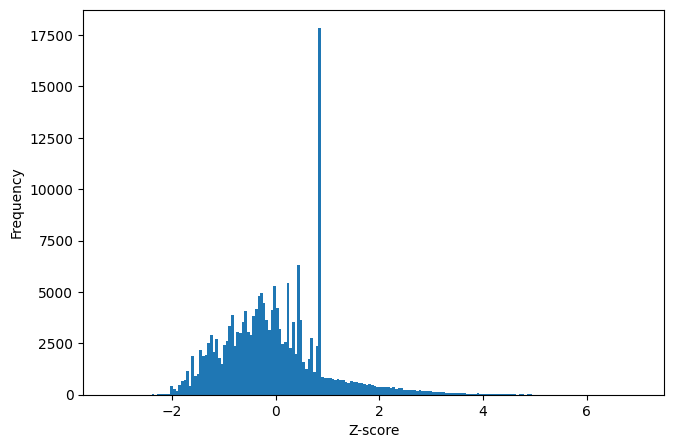

In [17]:
cov['Zscore'] = Zscore(cov['APC'])

plt.figure(figsize=(7.5,5))
cov['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
#plt.yscale('log')
#plt.savefig('results/DCA/nsP4/mfdca_nsp4_extended_Zscore_hist.png', dpi=400)
plt.show()

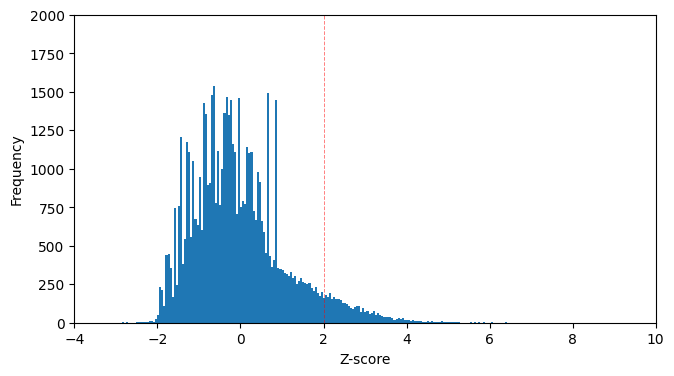

In [18]:
cov_ext_Nter = cov.query("first_site <105 or second_site < 105")

plt.figure(figsize=(7.5, 4))
cov_ext_Nter['Zscore'].plot(kind='hist', bins=200)
plt.xlabel('Z-score')
plt.xlim(-4,10)
plt.ylim(-0,2000)
plt.vlines(2, 0, 2000, color='red', linestyle='--', linewidth=0.7, alpha=0.5)
#plt.savefig('results/DCA/nsP4/v02/mfdca_nsp4_Nterm_extended_Zscore_hist.png', dpi=600, bbox_inches='tight')
plt.show()

In [19]:
cov_ext_Nter['Zscore'].min(), cov_ext_Nter['Zscore'].max()

(-3.204289380511997, 6.779000292841998)

## Adding Neff

In [20]:
neff = pd.read_excel('../results/Neff/nsP4/nsp4_extended_LUO_Neff_psiblast_mapped.xlsx')

df1 = cov_ext_Nter.merge(neff, left_on='first_site', right_on='residue', how='left')
df1.rename(columns={'Neff': 'first_site_Neff', 'residueName':'first_site_residue'}, inplace=True)
df1 = df1[['first_site_residue','first_site','first_site_Neff', 'second_site', 'Tuple', 'APC', 'Zscore',]]
df2 = df1.merge(neff, left_on='second_site', right_on='residue', how='left')
df2.rename(columns={'Neff': 'second_site_Neff', 'residueName':'second_site_residue'}, inplace=True)

cov_ext_Nter_neff = df2[['first_site_residue', 'first_site', 'first_site_Neff',
                            'second_site_residue', 'second_site', 'second_site_Neff',
                            'Tuple', 'APC', 'Zscore',]].copy()

#cov_ext_Nter_neff = cov_ext_Nter_neff.query("Zscore > 2")
cov_ext_Nter_neff['Tuple'] = cov_ext_Nter_neff['Tuple'].astype(str) 
cov_ext_Nter_neff

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779000
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038877,6.408405
2,Pro,103,1.114821,Glu,240,2.289969,"(103, 240)",0.038816,6.398358
3,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364198
4,Gly,83,1.000000,Asn,252,1.560988,"(83, 252)",0.038299,6.313073
...,...,...,...,...,...,...,...,...,...
58585,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742414
58586,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017077,-2.815829
58587,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835438
58588,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018062,-2.978159


### Adding distance in Å

In [21]:
extended_contact = pd.read_table('../results/Distance/nsP4/nsp4-SAXS-extended-conf-MDsimulated_V25E91_LUO_distance.txt')
cols=['Contact',	'Residue1_Name',	'Residue1_Pos',	'Residue2_Name',	'Residue2_Pos',	'Pairs',]
df = cov_ext_Nter_neff.merge(extended_contact, left_on='Tuple', right_on='Pairs', how='inner').drop(cols, axis=1)
df

,first_site_residue,first_site,first_site_Neff,second_site_residue,second_site,second_site_Neff,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,Pro,216,1.000000,"(75, 216)",0.041125,6.779000,23.37
1,Ala,89,4.551939,Ala,496,1.268383,"(89, 496)",0.038877,6.408405,49.80
2,Ser,57,1.867111,Asn,60,1.000000,"(57, 60)",0.038609,6.364198,6.19
3,Gly,83,1.000000,Asn,252,1.560988,"(83, 252)",0.038299,6.313073,25.07
4,Gln,53,1.014685,Pro,216,1.000000,"(53, 216)",0.038045,6.271344,40.32
...,...,...,...,...,...,...,...,...,...,...
55945,Glu,32,3.073293,Ile,510,1.215954,"(32, 510)",-0.016632,-2.742414,26.54
55946,Leu,48,1.148529,Ala,56,1.872983,"(48, 56)",-0.017077,-2.815829,10.97
55947,Leu,48,1.148529,Val,522,1.103899,"(48, 522)",-0.017196,-2.835438,54.47
55948,Ile,76,2.130973,Phe,589,1.989551,"(76, 589)",-0.018062,-2.978159,61.98


### Adding rASA

In [22]:
extended_rASA = pd.read_excel('../results/RSA/nsp4_RSA_MD_V25E91_LUO.xlsx', index_col=0)
extended_rASA.rename(columns={'rASA_extended': 'rASA'}, inplace=True)
extended_rASA

,Residue,position,rASA
0,Y,1,0.547529
1,I,2,0.131980
2,F,3,0.137500
3,S,4,0.083871
4,S,5,0.167742
...,...,...,...
606,Y,607,0.030418
607,G,608,0.346154
608,G,609,0.480769
609,P,610,0.817610


In [23]:
mapping = {k:v for k, v in zip(extended_rASA['position'], extended_rASA['rASA'])}


df['first_site_RSA'] = [mapping[x] for x in df['first_site']]
df['second_site_RSA'] = [mapping[x] for x in df['second_site']]

cols =['first_site_residue', 'first_site', 'first_site_Neff','first_site_RSA',
       'second_site_residue', 'second_site', 'second_site_Neff',  'second_site_RSA',
       'Tuple', 'APC', 'Zscore', 'Distance(Å)', ].copy()

df2 = df[cols]
df2

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
0,Met,75,4.808267,0.566964,Pro,216,1.000000,0.509434,"(75, 216)",0.041125,6.779000,23.37
1,Ala,89,4.551939,0.441860,Ala,496,1.268383,0.015504,"(89, 496)",0.038877,6.408405,49.80
2,Ser,57,1.867111,0.406452,Asn,60,1.000000,0.030769,"(57, 60)",0.038609,6.364198,6.19
3,Gly,83,1.000000,0.586538,Asn,252,1.560988,0.312821,"(83, 252)",0.038299,6.313073,25.07
4,Gln,53,1.014685,0.680000,Pro,216,1.000000,0.509434,"(53, 216)",0.038045,6.271344,40.32
...,...,...,...,...,...,...,...,...,...,...,...,...
55945,Glu,32,3.073293,0.452915,Ile,510,1.215954,0.000000,"(32, 510)",-0.016632,-2.742414,26.54
55946,Leu,48,1.148529,0.114428,Ala,56,1.872983,0.697674,"(48, 56)",-0.017077,-2.815829,10.97
55947,Leu,48,1.148529,0.114428,Val,522,1.103899,0.000000,"(48, 522)",-0.017196,-2.835438,54.47
55948,Ile,76,2.130973,0.274112,Phe,589,1.989551,0.000000,"(76, 589)",-0.018062,-2.978159,61.98


In [24]:
df2.to_csv('../results/DCA/nsP4/v02/res_nsp4_extended_LUO_Neff_RSA_APC_Zscore_Dist_Nter.csv', index=False)

## Contacts of SOI

In [25]:
ext_cont = pd.read_excel('../results/Neff/nsP4/nsp4_extended_LUO_SOI_neff.xlsx')
ext_cont = ext_cont[~ext_cont['nsp4'].isna()]
ext_cont['nsp4-Nter'].str.split('-').str[1]
ext_cont['contact_pairs'] = [x for x in zip(ext_cont['nsp4-Nter'].str.split('-').str[1].astype(int), ext_cont['nsp4'].str.split('-').str[1].astype(int))]
print(ext_cont.shape)
ext_cont

(30, 6)


,nsp4-Nter,Neff_nsp4-Nter,nsp4,Neff_nsp4,Interaction,contact_pairs
0,Thr-20,4.197054,Tyr-102,1.491985,bb-bb (Hb),"(20, 102)"
1,Asn-25,NaN,Thr-101,3.534660,Sc-bb (Hb),"(25, 101)"
2,Tyr-36,1.510676,Cys-233,1.000000,Sc-bb (Hb),"(36, 233)"
3,Lys-39,3.576069,Glu-226,1.106515,Sc-Sc (Hb),"(39, 226)"
4,Lys-81,2.954376,Glu-392,1.005156,NaN,"(81, 392)"
5,Lys-81,2.954376,Asp-393,1.000000,Sc-Sc (Hb),"(81, 393)"
6,Cys-84,3.909469,Ala-242,2.406731,Sc-bb (Hb),"(84, 242)"
7,Arg-85,3.167933,Asp-397,1.140274,Sc-Sc (Hb),"(85, 397)"
8,Ser-90,3.225319,Asp-91,NaN,Sc-bb (Hb),"(90, 91)"
9,Thr-21,4.545398,Pro-103,1.114821,Sc-Sc,"(21, 103)"


In [26]:
pairs = [str(x) for x in compact_cont['contact_pairs'].values]
res = df2.query('Tuple in @pairs')
res.sort_values('first_site')

,first_site_residue,first_site,first_site_Neff,first_site_RSA,second_site_residue,second_site,second_site_Neff,second_site_RSA,Tuple,APC,Zscore,Distance(Å)
26894,Thr,20,4.197054,0.203488,Thr,101,3.534660,0.255814,"(20, 101)",-0.001065,-0.176072,6.14
19886,Thr,20,4.197054,0.203488,Tyr,102,1.491985,0.007605,"(20, 102)",0.001241,0.204070,6.06
2241,Glu,29,3.290982,0.484305,His,31,3.652468,0.214286,"(29, 31)",0.014666,2.417235,6.58
740,Val,30,4.257909,0.856322,Arg,99,3.108927,0.339416,"(30, 99)",0.019599,3.230313,14.13
54669,Val,30,4.257909,0.856322,Arg,332,1.000000,0.306569,"(30, 332)",-0.010471,-1.726816,20.29
9483,Glu,33,1.178779,0.318386,Lys,34,2.460929,0.542373,"(33, 34)",0.005350,0.881435,3.87
42302,Cys,35,5.424846,0.502994,Thr,255,3.370633,0.319767,"(35, 255)",-0.005214,-0.860072,44.41
19583,Cys,35,5.424846,0.502994,Thr,258,1.692398,0.523256,"(35, 258)",0.001348,0.221712,48.41
17437,Tyr,36,1.510676,0.235741,Thr,258,1.692398,0.523256,"(36, 258)",0.002092,0.344311,46.84
41666,Pro,37,2.216466,0.477987,Thr,254,2.494927,0.040698,"(37, 254)",-0.005146,-0.848852,45.38


In [27]:
df.to_excel('../results/DCA/nsP4/v02/res_nsp4_extended_LUO_SOI_Neff_RSA_APC_Zscore_Dist_Nter.xlsx', index=False)